In [1]:
import os
from os import listdir, path
import pandas as pd
import matplotlib.pyplot as plt
import pickle

<h3> 尚未進行資料預處理前的各池塘總筆數 </h3>

In [2]:
df_ponds = dict()

# source
for i in range(2,5,1):
    df = pd.read_csv(f'./source/FishAquaponics_IoTpond{i}/IoTpond{i}.csv')
    df_ponds[f'IoTpond{i}'] = df

# target
for i in range(1,2,1):
    df = pd.read_csv(f'./target/FishAquaponics_IoTpond{i}/IoTpond{i}.csv')
    df_ponds[f'IoTpond{i}'] = df
    
df_ponds.keys() # 有哪些資料集。

dict_keys(['IoTpond2', 'IoTpond3', 'IoTpond4', 'IoTpond1'])

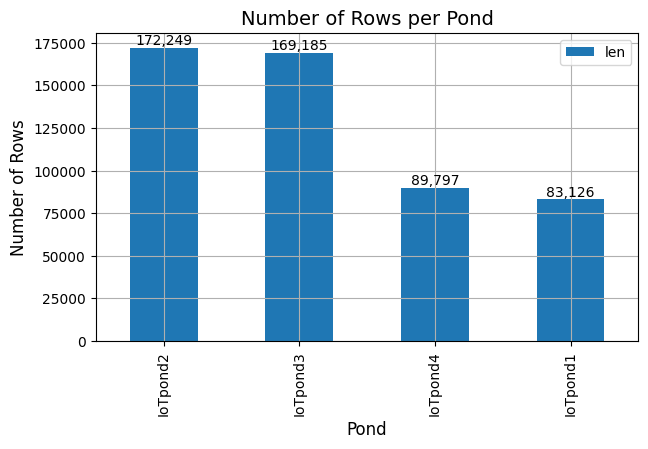

In [3]:
# 展示每個魚塘有多少測量資料。
df_size = pd.DataFrame([{"pond": k, "len": len(df_ponds[k])} for k in df_ponds])
ax = df_size.set_index("pond").plot.bar(figsize=(7, 4), grid=True)

# 在每個柱子上添加數值標籤，並以千分位格式顯示
for p in ax.patches:
    ax.annotate(f"{p.get_height():,}",  # 格式化數值為千分位
                (p.get_x() + p.get_width() / 2., p.get_height()),  # 標籤位置
                ha='center', va='bottom', fontsize=10, color='black')  # 對齊方式與樣式
    
ax.set_title("Number of Rows per Pond", fontsize=14)
ax.set_ylabel("Number of Rows", fontsize=12)
ax.set_xlabel("Pond", fontsize=12)

# 儲存圖片
plt.savefig("每個池塘資料行數統計圖.png", bbox_inches='tight')  # 儲存圖片，解析度為300 DPI
plt.show()

In [4]:
print(df_ponds['IoTpond1'].shape,
      df_ponds['IoTpond2'].shape,
      df_ponds['IoTpond3'].shape,
      df_ponds['IoTpond4'].shape)

(83126, 11) (172249, 11) (169185, 11) (89797, 15)


<p> Reference: aqpc-simple-pond-data-presentation </p>
https://www.kaggle.com/code/jirkaborovec/aqpc-simple-pond-data-presentation

<h3> 資料預處理後的各池塘總筆數 </h3>

<h4 style='color:blue'> Source DataSet 預訓練資料集 </h4>

In [5]:
# 用來儲存結果的字典
dataset_sizes = {
    "Dataset": [], # Dataset: 資料集名稱。
    "X_train": [], # X_train: 每個資料集的 X_train 样本數。
    "X_test": [], # X_test: 每個資料集的 X_test 样本數。
    "n_samples": [], # n_samples: 總樣本數。
    "n_features": [] # n_features: 特徵數。
}

In [6]:
def Read_DataSet(file: str):
    for dname in listdir(f'.\{file}'): # 針對於X_train.pkl及X_test.pkl檔案，計算樣本數和特徵數。
        print(dname)
        n_features = 0
        n_samples = 0
        train_size = 0
        test_size = 0
        
        for fname in listdir(path.join(f'.\{file}',dname)):
            if fname == "X_train.pkl" or fname == "X_test.pkl":
                with open(path.join(f'.\{file}', dname, fname),'rb') as f:
                    data = pickle.load(f)
    
                    if "X_train" in fname:
                        train_size = len(data)
                    elif "X_test" in fname:
                        test_size = len(data)
                    
                    n_samples += data.shape[0]
                    n_features = data.shape[1]
    
        # 將結果添加到字典中
        dataset_sizes["Dataset"].append(dname)
        dataset_sizes["X_train"].append(train_size)
        dataset_sizes["X_test"].append(test_size)
        dataset_sizes["n_samples"].append(n_samples)
        dataset_sizes["n_features"].append(n_features)
                    
        print(f'Samples : {n_samples}')
        print(f'Features : {n_features}')
        print('-'*30)
    
    return dataset_sizes

In [7]:
def split_ratio(Xtrain_len, Xtest_len):
    """
    Calculate the split ratio for training and testing datasets.
    """
    total_len = Xtrain_len + Xtest_len
    print('X_train, X_test, total:', Xtrain_len, Xtest_len, total_len)
    train_ratio = round(Xtrain_len / total_len * 100, 1)  # Convert to percentage
    test_ratio = round(Xtest_len / total_len * 100, 1)    # Convert to percentage
    print('Train-Test 切分比例:', train_ratio, test_ratio)
    return f"{train_ratio}%", f"{test_ratio}%"

In [8]:
def train_test_barPlot(dataset_sizes: dict):
    """
    Plot bar chart of X_train and X_test sizes across datasets with split ratio.
    """
    # Plot setup
    plt.figure(figsize=(12, 8))
    bar_width = 0.35
    index = range(len(dataset_sizes["Dataset"]))
    
    # 繪製 X_train 和 X_test 的柱狀圖
    bar_Xtrain = plt.bar(index, dataset_sizes["X_train"], bar_width, label="X_train")
    bar_Xtest = plt.bar([i + bar_width for i in index], dataset_sizes["X_test"], bar_width, label="X_test")

    # Add data labels with split ratios
    for i, (train_size, test_size) in enumerate(zip(dataset_sizes["X_train"], dataset_sizes["X_test"])):
        train_ratio, test_ratio = split_ratio(train_size, test_size)  # Calculate split ratio
        # Add split ratio labels inside bars
        plt.text(i, train_size / 2, train_ratio, ha='center', va='center', color='white', fontsize=10, fontweight='bold')
        plt.text(i + bar_width, test_size / 2, test_ratio, ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # 標籤與標題
    plt.xlabel("Dataset", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.title("Comparison of X_train and X_test Sizes Across Datasets", fontsize=16)

    # 設置 x 軸標籤顏色
    ax = plt.gca()
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(dataset_sizes["Dataset"], fontsize=10)
    for label, dataset in zip(ax.get_xticklabels(), dataset_sizes["Dataset"]):
        label.set_color('red' if dataset == 'FishAquaponics_IoTpond1' else 'black') # 獲取所有x軸標籤的文本對象，並對每個文本標籤用set_color()方法設置顏色。
    
    plt.legend(loc="best")
    
    # 在每個柱子上添加數值標籤
    for bar in bar_Xtrain:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{int(bar.get_height()):,}", ha='center', va='bottom', fontsize=10)
        
    for bar in bar_Xtest:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{int(bar.get_height()):,}", ha='center', va='bottom', fontsize=10)
    
    # 顯示圖表
    plt.tight_layout()
    plt.savefig('Comparison of X_train and X_test Sizes Across Datasets.png', bbox_inches='tight')
    plt.show()

In [9]:
Read_DataSet('source')

FishAquaponics_IoTpond2
Samples : 82099
Features : 7
------------------------------
FishAquaponics_IoTpond3
Samples : 63170
Features : 7
------------------------------
FishAquaponics_IoTpond4
Samples : 45784
Features : 7
------------------------------


{'Dataset': ['FishAquaponics_IoTpond2',
  'FishAquaponics_IoTpond3',
  'FishAquaponics_IoTpond4'],
 'X_train': [65679, 50536, 36627],
 'X_test': [16420, 12634, 9157],
 'n_samples': [82099, 63170, 45784],
 'n_features': [7, 7, 7]}

X_train, X_test, total: 65679 16420 82099
Train-Test 切分比例: 80.0 20.0
X_train, X_test, total: 50536 12634 63170
Train-Test 切分比例: 80.0 20.0
X_train, X_test, total: 36627 9157 45784
Train-Test 切分比例: 80.0 20.0


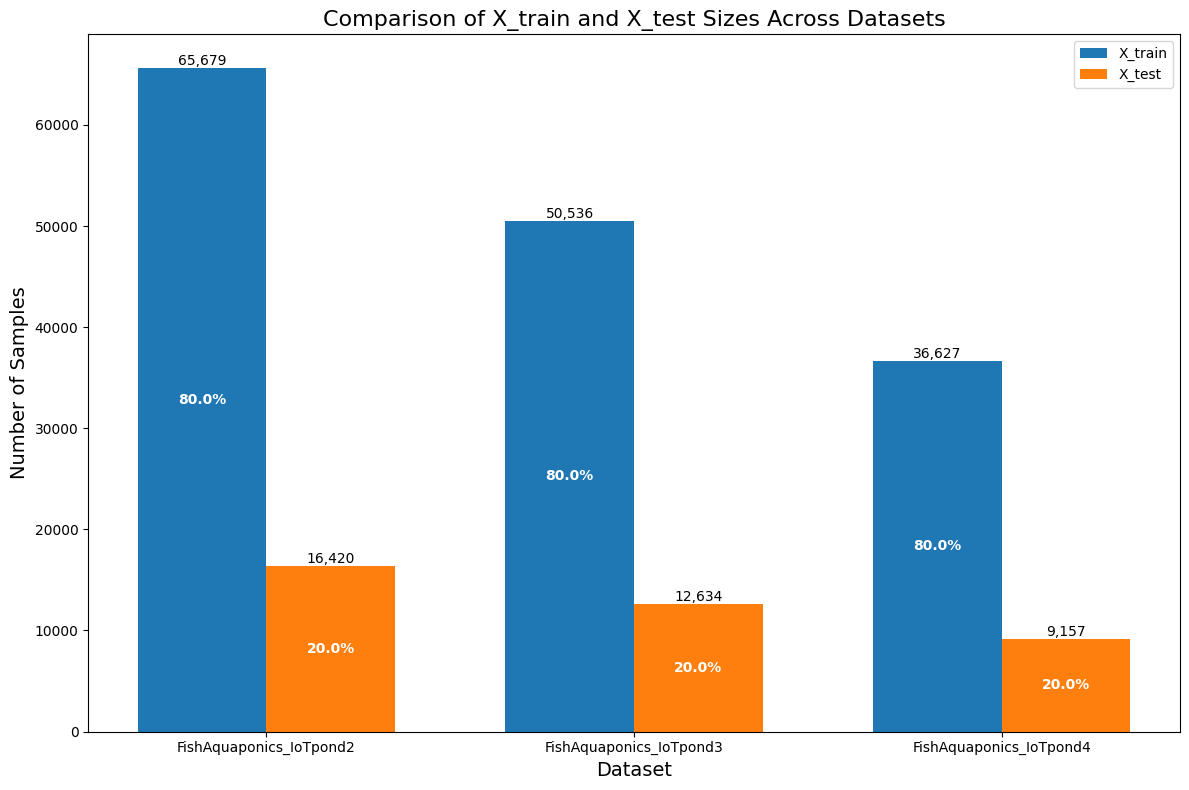

In [10]:
train_test_barPlot(dataset_sizes)

<h4 style='color:red'> Target DataSet 目標資料集 </h4>

In [11]:
Read_DataSet('target')

FishAquaponics_IoTpond1
Samples : 41726
Features : 7
------------------------------


{'Dataset': ['FishAquaponics_IoTpond2',
  'FishAquaponics_IoTpond3',
  'FishAquaponics_IoTpond4',
  'FishAquaponics_IoTpond1'],
 'X_train': [65679, 50536, 36627, 8345],
 'X_test': [16420, 12634, 9157, 33381],
 'n_samples': [82099, 63170, 45784, 41726],
 'n_features': [7, 7, 7, 7]}

X_train, X_test, total: 65679 16420 82099
Train-Test 切分比例: 80.0 20.0
X_train, X_test, total: 50536 12634 63170
Train-Test 切分比例: 80.0 20.0
X_train, X_test, total: 36627 9157 45784
Train-Test 切分比例: 80.0 20.0
X_train, X_test, total: 8345 33381 41726
Train-Test 切分比例: 20.0 80.0


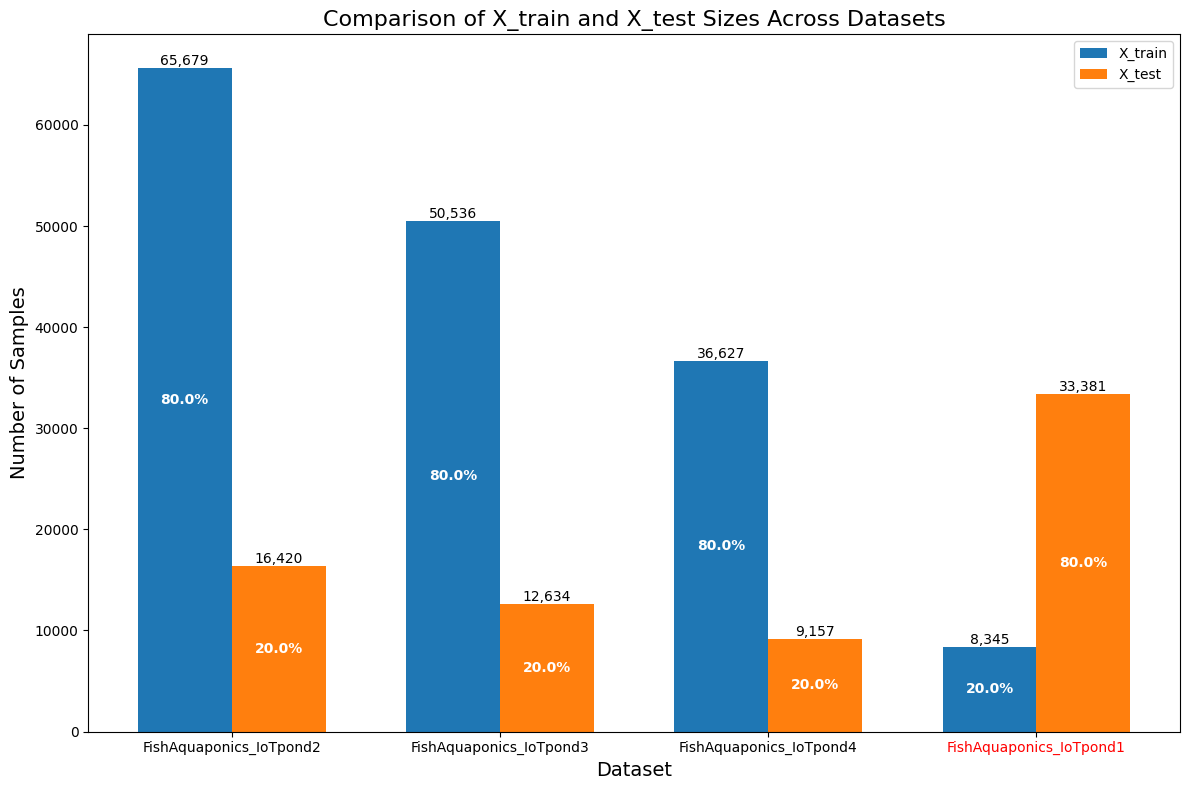

In [12]:
train_test_barPlot(dataset_sizes)